# Beispiel 18.5: Gas-Flüssig-Reaktion 2. Ordnung in einem Rührkesselreaktor
Bearbeitet von Franz Braun

Dieses Beispiel befindet sich im Lehrbuch auf den Seiten 287 - 289. Die Nummerierung
der verwendeten Gleichungen entspricht der Nummerierung im Lehrbuch. Das hier angewendete
Vorgehen entspricht dem im Lehrbuch vorgestellten Lösungsweg.

Zunächst werden die benötigten Pakete importiert.

In [16]:
### Import
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root
from tabulate import tabulate

Die Reaktionskinetik für die betrachtete Reaktion ($\mathrm{A_1} +\mathrm{A_2} \rightarrow \mathrm{A_3}$) ist geben als:

\begin{align*}
r_\mathrm{L} = k\, c_{c_1,\mathrm{L}} \, c_{c_1,\mathrm{L}}.
\end{align*}

Für die Komponenten $\mathrm{A_1}$, $\mathrm{A_2}$ und $\mathrm{A_3}$ ergeben sich die stationären, dimensionslosen Materialbilanzen für eine Reaktion 2. Ordnung im flüssigkeitsseitigen Grenzfilm (Mesoskala) und für $D_\mathrm{1,L} = D_\mathrm{2,L} = D_\mathrm{3,L}$ aus Gleichung 18.15a zu:

\begin{align*}
\frac{\mathrm{d} f_\mathrm{1,L}^2}{\mathrm{d}^2\chi} &=  Ha^2 f_\mathrm{1,L}\, f_\mathrm{1,L},\\
\frac{\mathrm{d} f_\mathrm{2,L}^2}{\mathrm{d}^2\chi} &=  Ha^2 f_\mathrm{1,L}\, f_\mathrm{1,L},\\
\frac{\mathrm{d} f_\mathrm{3,L}^2}{\mathrm{d}^2\chi} &= -Ha^2 f_\mathrm{1,L}\, f_\mathrm{1,L}.
\end{align*}

Die Materialbilanzen werden in folgender Funktion implementiert.

In [17]:
def material(X, y):
    '''
    Dimensionslose Materialbilanz (Mesoskala) für die Reaktion 2.Ordnung (Gleichung 18.15a)
    y[0]       : Restanteil von A1
    y[1]       : Restanteil von A2
    y[2]       : Restanteil von A3
    y[3]       : erste Ableitung des Restanteils von A1 nach der dimensionslosen Ortskoordinate
    y[4]       : erste Ableitung des Restanteils von A2 nach der dimensionslosen Ortskoordinate   
    y[5]       : erste Ableitung des Restanteils von A3 nach der dimensionslosen Ortskoordinate
    dy2dX2     : zweite Ableitung der Restanteile von nach der dimensionslosen Ortskoordinate (Vektor der Größe 2)
    X          : Ortskoordinate
    '''
    f = y[:3]  # Vektor für die Restanteile von A1, A2 und A2 

    dy2dX2 = np.empty_like(f)

    dy2dX2[0] =   Ha**2 * f[0] * f[1]
    dy2dX2[1] =   Ha**2 * f[0] * f[1]
    dy2dX2[2] = - Ha**2 * f[0] * f[1]
    

    return np.vstack((y[3:],dy2dX2))

Die dazugehörigen Randbedingungen an der Grenzfläche zwischen flüssigkeitsseitigem Grenzfilm und Kernströmung, also für $\chi = 1$,
lauten unter der Annahme $D_\mathrm{1,L} = D_\mathrm{2,L} = D_\mathrm{3,L}$ (s. Gleichung 18.17 und Tabelle 18.3):

\begin{align*}
f_\mathrm{1,L}(\chi = 1) & = f_\mathrm{1,L,b},\\
f_\mathrm{2,L}(\chi = 1) & = f_\mathrm{2,L,b},\\
f_\mathrm{3,L}(\chi = 1) & = f_\mathrm{3,L,b}.
\end{align*}

An der Stelle $\chi = 0$ (Phasengrenzfläche) werden gem. Gleichung 18.16 folgende Randbedingungen angesetzt (s. Tabelle 18.3 und Erläuterung Lehrbuchtext zu Beispiel 18.5):

\begin{align*}
f_\mathrm{1,L}(\chi = 0) & = f_\mathrm{1,G,b} = 1,\\
\frac{\mathrm{d} f_\mathrm{2,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 0}\normalsize & = 0,\\
\frac{\mathrm{d} f_\mathrm{3,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 0}\normalsize & = 0.
\end{align*}

Für die Berechnung der erforderlichen Restanteile von $A_1$, $A_2$  und $A_3$ in der Kernströmung der Flüssigkeit $f_{i,\mathrm{L,b}}$ werden die stationären Bilanzgleichungen auf der Reaktorskala (Mesoskala) auf Basis von Gleichung 18.38b formuliert. Es wird angenommen, dass $c_\mathrm{1,L,e} = c_\mathrm{3,L,e} = 0$. Das Einsatzverhältnis ist $\kappa_\mathrm{2,L} = 2$.  Es ergibt sich:

\begin{align*}
0 &= - f_\mathrm{1,L,b} - \frac{Da_\mathrm{I}}{Hi \, Ha^2} \frac{\mathrm{d} f_\mathrm{1,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 1} \normalsize - Da_\mathrm{I} \frac{Hi - 1 }{Hi} f_\mathrm{1,L,b}\,f_\mathrm{2,L,b},\\
0 &= \kappa_\mathrm{2,L} - f_\mathrm{2,L,b} - \frac{Da_\mathrm{I}}{Hi \, Ha^2} \frac{\mathrm{d} f_\mathrm{2,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 1} \normalsize - Da_\mathrm{I} \frac{Hi - 1 }{Hi} f_\mathrm{1,L,b}\,f_\mathrm{2,L,b},\\
0 &= - f_\mathrm{3,L,b} - \frac{Da_\mathrm{I}}{Hi \, Ha^2} \frac{\mathrm{d} f_\mathrm{3,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 1} \normalsize + Da_\mathrm{I} \frac{Hi - 1 }{Hi} f_\mathrm{1,L,b}\,f_\mathrm{2,L,b},
\end{align*}

Die Randbedingungen werden in der Funktion _bc_material_ implementiert, die auch die Berechung der Restanteile in der Kernströmung enthält.

In [18]:
def bc_material(y0, y1):
    '''
    Randbedingungen der Materialbilanz
    y0    : Randbedingungen bei X = 0; 
                Vektor der Größe 4 : (Restanteil A1, Restanteil A2, Restanteil A3, Ableitung des Restanteils A1 nach der Ortskoordinate, Ableitung des Restanteils A2 nach der Ortskoordinate, 
                Ableitung des Restanteils A3 nach der Ortskoordinate)
    y1    : Randbedingungen bei X = 1;
                Vektor der Größe 4 : (Restanteil A1, Restanteil A2, Restanteil A3, Ableitung des Restanteils A1 nach der Ortskoordinate, Ableitung des Restanteils A2 nach der Ortskoordinate, 
                Ableitung des Restanteils A3 nach der Ortskoordinate)
    f_L_b : Restanteil von A1, A2 und A3 in der Kernströmung
    f_G_b : Restanteil von A1, A2 und A3 im Bulk des Gases
    '''

    # Berechnung der Restanteile in der Kernströmung der Flüssigkeit f_L_b (Bilanz Makroskala)
    f_L_b = np.empty(3)
    f_L_b[0] = - Da_I / (Hi * Ha**2) * y1[3] - (1 + Da_I * (Hi - 1) / Hi) * y1[0]*  y1[1]
    f_L_b[1] = kappa_2 - Da_I / (Hi * Ha**2) * y1[4] - (1 + Da_I * (Hi - 1) / Hi) * y1[0]*  y1[1]     
    f_L_b[2] = - Da_I / (Hi * Ha**2) * y1[5] + (1 + Da_I * (Hi - 1) / Hi) * y1[0]*  y1[1]
    
    BC = np.empty(nu.size *2)  # 2 Randbedingungen (RB) pro Komponente
    # A1
    BC[0] = y0[0] - f_1_G_b    # RB an der Stelle X = 0 für Komponente A1 : 0 = f_1,L(X = 0) - f_1,G,b
    BC[1] = y1[0] - f_L_b[0]   # RB an der Stelle X = 1 für Komponente A1 : 0 = f_1,L(X = 1) - f_1,L,b
    # A2
    BC[2] = y0[4]              # RB an der Stelle X = 0 für Komponente A2 : 0 = df_2dX(X = 0)
    BC[3] = y1[1] - f_L_b[1]   # RB an der Stelle X = 1 für Komponente A2 : 0 = f_2,L(X = 1) - f_2,L,b
    # A3
    BC[4] = y0[5]              # RB an der Stelle X = 0 für Komponente A3 : 0 = df_3dX(X = 0)
    BC[5] = y1[2] - f_L_b[2]   # RB an der Stelle X = 1 für Komponente A3 : 0 = f_3,L(X = 1) - f_3,L,b
    
    return BC

Danach werden die stöchiometrischen Koeffizienten gemäß der Reaktionsgleichung, die Hatta-Zahl und der Restanteil von $A_1$ in der Kernströmung des Gases parametriert. 

In [19]:
Hi          = 100                    # Hinterland-Verhältnis
kappa_2     = 2                      # Einsatzverhältnis
nu          = np.array((-1,-1,1))    # Stöchiometrische Koeffizienten für A1, A3 
f_1_G_b     = np.array((1))          # Restanteil von A1 in der Kernströmung des Gases

Da der Einfluss verschiedener  Dammköhler-Zahlen $(Da_I)$ und Hinterland-Verhältnisse $(Hi)$ betrachtet werden soll, erfolgt die Variation von $Da_I$ und $Hi$ jeweils in einer For-Schleife. Die Profile der Restanteile werden durch den Aufruf eines Solvers für Randwertprobleme (solve_bvp) auf Grundlage der Materialbilanzen und der Randbedingungen berechnet.

In [20]:
Da_I_vec      = np.array((1, 3, 10))             # Vektor mit Dammköhler-Zahlen für Beispiel 18.5
Ha_vec        = np.array((0.3, 1, 10))           # Vektor mit Hatta-Zahlen für Beispiel 18.5

Lösungen_Ha_1 = []                               # Leere Liste zum Speichern der Lösungen für Ha = 0,3
Lösungen_Ha_2 = []                               # Leere Liste zum Speichern der Lösungen für Ha = 1
Lösungen_Ha_3 = []                               # Leere Liste zum Speichern der Lösungen für Ha = 10
N             = 101                              # Diskretisierung
X             = np.linspace(0, 1, N)             # Diskretisierung der Ortskoordinate
init_f        = np.ones((3, N))                  # Startwerte für Restanteile
init_df       = np.ones((3, N)) *1e-6            # Startwerte für die Ableitungen der Restanteile
init          = np.vstack((init_f, init_df))     # Zusammengefügte Startwerte für die Iterationen des Solvers


for DaDa in Da_I_vec:
    Ha     = Ha_vec[0]
    Da_I   = DaDa
    sol    = solve_bvp(material, bc_material, X, init , max_nodes = 1e10, tol = 1e-10)
    if sol.success == False:
        print(sol)
    Lösungen_Ha_1.append(sol)

for DaDa in Da_I_vec:
    Ha     = Ha_vec[1]
    Da_I   = DaDa
    sol    = solve_bvp(material, bc_material, X, init , max_nodes = 1e10, tol = 1e-10)
    if sol.success == False:
        print(sol)
    Lösungen_Ha_2.append(sol)

for DaDa in Da_I_vec:
    Ha     = Ha_vec[2]
    Da_I   = DaDa
    sol    = solve_bvp(material, bc_material, X, init , max_nodes = 1e10, tol = 1e-10)
    if sol.success == False:
        print(sol)
    Lösungen_Ha_3.append(sol)


Lösungen_Ha_1 = np.array((Lösungen_Ha_1))
Lösungen_Ha_2 = np.array((Lösungen_Ha_2))
Lösungen_Ha_3 = np.array((Lösungen_Ha_3))

 Abschließend werden die Ergebnisse grafisch veranschaulicht.

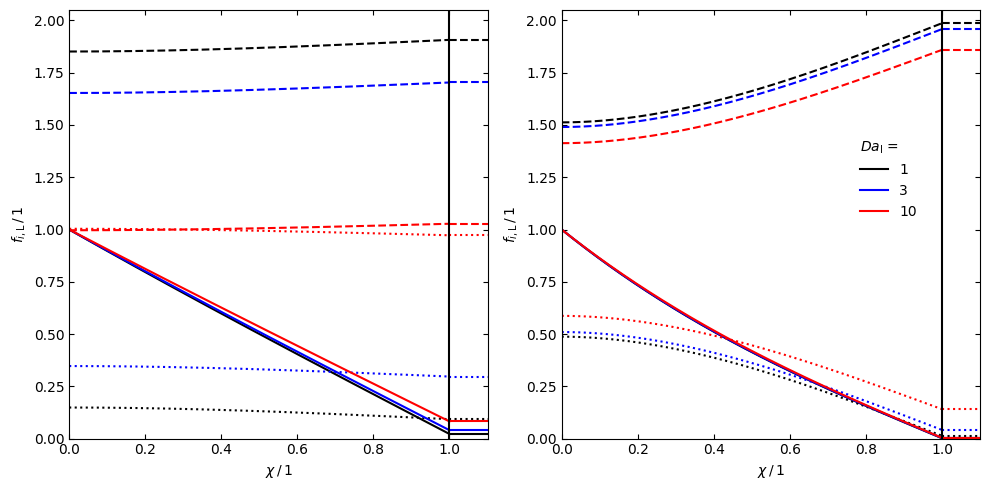

In [21]:
colors_Da = ['black','blue','red']

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
for Lösung, Da, color in zip(Lösungen_Ha_1,Da_I_vec,colors_Da):
    ax[0].plot(Lösung.x, Lösung.y[0], label = str(Da), color = color)
    ax[0].hlines(y=Lösung.y[0][-1], xmin=1, xmax=1.1, colors = color)
    ax[0].plot(Lösung.x, Lösung.y[1], color = color, linestyle = '--')
    ax[0].hlines(y=Lösung.y[1][-1], xmin=1, xmax=1.1, colors = color, linestyle = '--')
    ax[0].plot(Lösung.x, Lösung.y[2], color = color, linestyle = ':')
    ax[0].hlines(y=Lösung.y[2][-1], xmin=1, xmax=1.1, colors = color, linestyle = ':')

for Lösung, Da, color in zip(Lösungen_Ha_2,Da_I_vec,colors_Da):
    ax[1].plot(Lösung.x, Lösung.y[0], label = str(Da), color = color)
    ax[1].hlines(y=Lösung.y[0][-1], xmin=1, xmax=1.1, colors = color)
    ax[1].plot(Lösung.x, Lösung.y[1], color = color, linestyle = '--')
    ax[1].hlines(y=Lösung.y[1][-1], xmin=1, xmax=1.1, colors = color, linestyle = '--')
    ax[1].plot(Lösung.x, Lösung.y[2], color = color, linestyle = ':')
    ax[1].hlines(y=Lösung.y[2][-1], xmin=1, xmax=1.1, colors = color, linestyle = ':')

ax[0].vlines(x=1, ymin=0, ymax=3, colors='black')
ax[0].set_xlim(0,1.1)
ax[0].set_ylim(0,2.05)
ax[0].tick_params(axis="y",direction="in", right = True)
ax[0].tick_params(axis="x",direction="in", top = True)
ax[0].set_ylabel(r'$f_{i,\mathrm{L}}\,/\,1$')
ax[0].set_xlabel(r'$\chi \,/\,1$')

ax[1].vlines(x=1, ymin=0, ymax=3, colors='black')
ax[1].set_ylabel(r'$f_{i,\mathrm{L}}\,/\,1$')
ax[1].set_xlabel(r'$\chi \,/\,1$')
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(0,2.05)
ax[1].tick_params(axis="y",direction="in", right = True)
ax[1].tick_params(axis="x",direction="in", top = True)
ax[1].legend(title = '$Da_\mathrm{I}$ =',frameon = False, alignment = 'left',ncol=1,loc=(0.7,0.5))
plt.tight_layout()
plt.show()

Für die Betrachtung des Einflusses von $Ha$ und $Da_\mathrm{I}$ auf den Nutzungsgrad des Flüssigkeitsfilms $\eta_\mathrm{L,Film}$, den Nutzungsgrad der Kernströmung $\eta_\mathrm{L,b}$, den Nutzungsgradverlust $\Delta\eta_\mathrm{L}$ und den Verstärkungsfaktor $E$ werden folgende Gleichungen ausgewertet (s. Beispiel 18.4 im Lehrbuch):

\begin{align*}
E &= \frac{\frac{\mathrm{d} f_\mathrm{1,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 0}}{f_{1,\chi = 1}-f_{1,\chi = 0}} \\
\eta_\mathrm{L,Film} &= 1 - \frac{\dot{n}_{1,\chi = 1}}{\dot{n}_{1,\chi = 0}} = 1 - \frac{J_{1,\chi = 1}}{J_{1,\chi = 0}} = 1 - \frac{\frac{\mathrm{d} f_\mathrm{1,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 1}}{\frac{\mathrm{d} f_\mathrm{1,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 0}}\\
\Delta\eta_\mathrm{L} &= \frac{\dot{n}_\mathrm{1,L,a} - \dot{n}_\mathrm{1,L,e}}{\dot{n}_{1,\chi = 0}} = - \frac{Hi\,Ha^2}{Da_\mathrm{I}} \frac{f_\mathrm{1,L,b}}{\frac{\mathrm{d} f_\mathrm{1,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 0}}\\
\eta_\mathrm{L,b} &= 1 - \eta_\mathrm{L,Film} - \Delta\eta_\mathrm{L}
\end{align*}

Diese Berechnungsvorschriften werden jeweils als Funktionen wie folgt implementiert.

In [22]:
def cal_E(dfdx_0, f_0, f_1):
    '''
    Berechnung des Verstärkungsfaktors
    dfdx_0 : Ableitung des Restanteils nach der Ortskoordinate an der Stelle X = 0
    f_0    : Restanteil an der Stelle X = 0
    f_1    : Restanteil an der Stelle X = 1
    '''
    return dfdx_0 / (f_1 - f_0)

def cal_eta_L_Film(dfdx_1, dfdx_0):
    '''
    Berechnung des Nutzungsgrads des Flüssigkeitsfilms
    dfdx_1 : Ableitung des Restanteils nach der Ortskoordinate an der Stelle X = 1
    dfdx_0 : Ableitung des Restanteils nach der Ortskoordinate an der Stelle X = 0
    '''
    return 1 - dfdx_1 / dfdx_0


def cal_Delta_eta_L(Hi, Ha, Da, f_1_L_b, dfdx_0):
    '''
    Berechnung des Nutzungsgradverlusts
    dfdx_0  : Ableitung des Restanteils nach der Ortskoordinate an der Stelle X = 0
    Hi      : Hinterland-Verhältnis
    Da      : Dammköhler-Zahl
    Ha      : Hatta-Zahl
    f_1_L_b : Restanteil von A1 in der Kernströmung der Flüssigkeit
    '''
    return - Hi * Ha**2 / Da * f_1_L_b / dfdx_0

def cal_eta_L_b(eta_L_Film, Delta_eta_L):
    '''
    Berechnung des Nutzungsgrads der Kernströmung
    eta_L_Film  : Nutzungsgrads des Flüssigkeitsfilms
    Delta_eta_L : Nutzungsgradverlust
    '''
    return 1 - eta_L_Film - Delta_eta_L

Die Berechnungen für verschiedene $Ha$ und $Da_\mathrm{I}$ erfolgen jeweils in einer For-Schleife.

In [23]:
Res_Ha_1 = [] # leere Liste zum Speichern der Ergebnisse für verschiedene Ha = 0,3
Res_Ha_2 = [] # leere Liste zum Speichern der Ergebnisse für verschiedene Ha = 1
Res_Ha_3 = [] # leere Liste zum Speichern der Ergebnisse für verschiedene Ha = 10

# Berechnung für Ha = 0,3
for Lösung, Da in zip(Lösungen_Ha_1, Da_I_vec):
    Ha     = Ha_vec[0]
    Da_I   = Da
    Res    = np.empty(4) # Array der Größe 4 zum Speichern von E, eta_L_Film, Delta_eta_L, eta_L_b
    Res[0] = cal_E(Lösung.y[3,0], Lösung.y[0,0], Lösung.y[0,-1])
    Res[1] = cal_eta_L_Film(Lösung.y[3,-1], Lösung.y[3,0])
    Res[2] = cal_Delta_eta_L(Hi, Ha, Da_I, Lösung.y[0,-1], Lösung.y[3,0])
    Res[3] = cal_eta_L_b(Res[1], Res[2])
    Res_Ha_1.append(Res)

Res_Ha_1 = np.array((Res_Ha_1))



# Berechnung für Ha = 1
for Lösung, Da in zip(Lösungen_Ha_2, Da_I_vec):
    Ha     = Ha_vec[1]
    Da_I   = Da
    Res    = np.empty(4) # Array der Größe 4 zum Speichern von E, eta_L_Film, Delta_eta_L, eta_L_b
    Res[0] = cal_E(Lösung.y[3,0],Lösung.y[0,0], Lösung.y[0,-1])
    Res[1] = cal_eta_L_Film(Lösung.y[3,-1],Lösung.y[3,0])
    Res[2] = cal_Delta_eta_L(Hi, Ha, Da_I, Lösung.y[0,-1],Lösung.y[3,0])
    Res[3] = cal_eta_L_b(Res[1],Res[2])
    Res_Ha_2.append(Res)

Res_Ha_2 = np.array((Res_Ha_2))

# Berechnung für Ha = 10
for Lösung, Da in zip(Lösungen_Ha_3, Da_I_vec):
    Ha     = Ha_vec[2]
    Da_I   = Da
    Res    = np.empty(4) # Array der Größe 4 zum Speichern von E, eta_L_Film, Delta_eta_L, eta_L_b
    Res[0] = cal_E(Lösung.y[3,0],Lösung.y[0,0], Lösung.y[0,-1])
    Res[1] = cal_eta_L_Film(Lösung.y[3,-1], Lösung.y[3,0])
    Res[2] = cal_Delta_eta_L(Hi, Ha, Da_I, Lösung.y[0,-1], Lösung.y[3,0])
    Res[3] = cal_eta_L_b(Res[1], Res[2])
    Res_Ha_3.append(Res)

Res_Ha_3 = np.array((Res_Ha_3))

comb_Res        = np.hstack((Res_Ha_1.T, Res_Ha_2.T, Res_Ha_3.T)) # Kombinierter Vektor der Ergebnisse
comb_Res[[2,3]] = comb_Res[[3,2]]                                 # Tauschen der letzten mit der vorletzten Reihe

Die Ergebnisse werden in einer Tabelle ausgegeben.

In [24]:
# Ausgabe der Ergebnisse als Tabelle

names_y  = np.array((['Ha / 1'], ['Da_I / 1'], ['E / 1'], ['eta_L_Film / 1'], ['eta_L_b / 1'], ['Delta_eta_L / 1']))
Ha_table = np.array((0.3, 0.3, 0.3, 1, 1, 1, 10, 10, 10))  
Da_table = np.array((1, 3, 10, 1, 3, 10, 1, 3, 10))

# Array für Tabelle
table = np.hstack((names_y,np.vstack((Ha_table, Da_table, np.round(comb_Res, 2)))))

print(tabulate(table))

---------------  ----  ----  -----  ----  ----  -----  -----  -----  -----
Ha / 1           0.3   0.3    0.3   1     1      1     10     10     10
Da_I / 1         1     3     10     1     3     10      1      3     10
E / 1            1.06  1.05   1.03  1.48  1.47   1.45   2.97   2.97   2.96
eta_L_Film / 1   0.08  0.08   0.05  0.48  0.48   0.46   1      1      1
eta_L_b / 1      0.73  0.8    0.87  0.41  0.46   0.51   0      0      0
Delta_eta_L / 1  0.19  0.12   0.08  0.1   0.06   0.03   0      0      0
---------------  ----  ----  -----  ----  ----  -----  -----  -----  -----


Die hier ermittelten Zahlenwerte weichen leicht von denen in Tabelle 18.4 des Lehrbuchs ab, insbesondere bei $Da_I = 1$. Nach umfangreicher Überprüfung möglicher Ursachen lässt sich das hauptsächlich auf numerische Gründe zurückführen. Zur Erzeugung der Ergebnisse im Buch wurde der _bvp4c_ Solver aus MatLab mit einer Toleranz von $10^{-3}$ verwendet, wohingegen hier der solver _scipy.integrate.solve_bvp_ mit einer Toleranz von $10^{-10}$ verwendet wird.

## Alternative Lösung mit anderer Randbedingung

Alternativ zu den Randbedingung im Buch aus der Tabelle 18.3 kann ein Ansatz über die Biot-Zahl $Bi$ gewählt werden, um strukturell gas- und flüssigkeitsseitigen Stofftransport zu berücksichtigen. Die Biot-Zahl wird aber sehr groß ($Bi = 10^{6}$) gewählt, so dass gasseitige Gradienten ausgeschlossen werden können und effektiv die Randbedingungen gem. Tabelle 18.3 im Lehrbuch vorliegen. 
Die Randbedingung an der Phasengrenzfläche ($\chi = 0$) der gasförmigen Komponente A1 ändert sich dementsprechend zu:

\begin{align*} 
\frac{\mathrm{d} f_\mathrm{1,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 0} = Bi \, (f_\mathrm{1,L} - f_\mathrm{1,G,b}).
\end{align*}

In [25]:
def bc_material(y0, y1):
    '''
    Randbedingungen der Materialbilanz
    y0    : Randbedingungen bei X = 0; 
                Vektor der Größe 4 : (Restanteil A1, Restanteil A2, Restanteil A3, Ableitung des Restanteils A1 nach der Ortskoordinate, Ableitung des Restanteils A2 nach der Ortskoordinate, 
                Ableitung des Restanteils A3 nach der Ortskoordinate)
    y1    : Randbedingungen bei X = 1;
                Vektor der Größe 4 : (Restanteil A1, Restanteil A2, Restanteil A3, Ableitung des Restanteils A1 nach der Ortskoordinate, Ableitung des Restanteils A2 nach der Ortskoordinate, 
                Ableitung des Restanteils A3 nach der Ortskoordinate)
    f_L_b : Restanteil von A1, A2 und A3 in der Kernströmung
    f_G_b : Restanteil von A1, A2 und A3 im Bulk des Gases
    '''

    # Berechnung der Restanteile in der Kernströmung der Flüssigkeit f_L_b (Bilanz Makroskala)
    f_L_b = np.empty(3)
    f_L_b[0] = - Da_I / (Hi * Ha**2) * y1[3] - (1 + Da_I * (Hi - 1) / Hi) * y1[0]*  y1[1]
    f_L_b[1] = kappa_2 - Da_I / (Hi * Ha**2) * y1[4] - (1 + Da_I * (Hi - 1) / Hi) * y1[0]*  y1[1]     
    f_L_b[2] = - Da_I / (Hi * Ha**2) * y1[5] + (1 + Da_I * (Hi - 1) / Hi) * y1[0]*  y1[1]
    
    BC = np.empty(nu.size *2)  # 2 Randbedingungen (RB) pro Komponente
    # A1
    BC[0] = y0[3] - Bi * (y0[0] - f_1_G_b)    # RB an der Stelle X = 0 für Komponente A1 : df_1dX(X = 0) = Bi * (f_1,L(X = 0) - f_1_G_b)    
    BC[1] = y1[0] - f_L_b[0]                  # RB an der Stelle X = 1 für Komponente A1 : 0 = f_1,L(X = 1) - f_1,L,b
    # A2
    BC[2] = y0[4]                             # RB an der Stelle X = 0 für Komponente A2 : 0 = df_2dX(X = 0)
    BC[3] = y1[1] - f_L_b[1]                  # RB an der Stelle X = 1 für Komponente A2 : 0 = f_2,L(X = 1) - f_2,L,b
    # A3
    BC[4] = y0[5]                             # RB an der Stelle X = 0 für Komponente A3 : 0 = df_3dX(X = 0)
    BC[5] = y1[2] - f_L_b[2]                  # RB an der Stelle X = 1 für Komponente A3 : 0 = f_3,L(X = 1) - f_3,L,b
    
    return BC

Nach der Definition der neuen Randbedingung wird die Biot-Zahl parametriert.

In [26]:
Bi          = 1e6                    # Biot-Zahl

Anschließend wird das System mit der neuen Randbedingung wieder für verschiedene Dammköhler-Zahlen $(Da_I)$ und Hinterland-Verhältnisse $(Hi)$ gelöst und die Lösung grafisch veranschaulicht.

In [27]:
Da_I_vec      = np.array((1, 3, 10))             # Vektor mit Dammköhler-Zahlen für Beispiel 18.5
Ha_vec        = np.array((0.3, 1, 10))           # Vektor mit Hatta-Zahlen für Beispiel 18.5

Lösungen_Ha_1 = []                               # Leere Liste zum Speichern der Lösungen für Ha = 0,3
Lösungen_Ha_2 = []                               # Leere Liste zum Speichern der Lösungen für Ha = 1
Lösungen_Ha_3 = []                               # Leere Liste zum Speichern der Lösungen für Ha = 10
N             = 101                              # Diskretisierung
X             = np.linspace(0, 1, N)             # Diskretisierung der Ortskoordinate
init_f        = np.ones((3, N))                  # Startwerte für Restanteile
init_df       = np.ones((3, N)) *1e-6            # Startwerte für die Ableitungen der Restanteile
init          = np.vstack((init_f, init_df))     # Zusammengefügte Startwerte für die Iterationen des Solvers


for DaDa in Da_I_vec:
    Ha     = Ha_vec[0]
    Da_I   = DaDa
    sol    = solve_bvp(material, bc_material, X, init , max_nodes = 1e10, tol = 1e-10)
    if sol.success == False:
        print(sol)
    Lösungen_Ha_1.append(sol)

for DaDa in Da_I_vec:
    Ha     = Ha_vec[1]
    Da_I   = DaDa
    sol    = solve_bvp(material, bc_material, X, init , max_nodes = 1e10, tol = 1e-10)
    if sol.success == False:
        print(sol)
    Lösungen_Ha_2.append(sol)

for DaDa in Da_I_vec:
    Ha     = Ha_vec[2]
    Da_I   = DaDa
    sol    = solve_bvp(material, bc_material, X, init , max_nodes = 1e10, tol = 1e-10)
    if sol.success == False:
        print(sol)
    Lösungen_Ha_3.append(sol)


Lösungen_Ha_1 = np.array((Lösungen_Ha_1))
Lösungen_Ha_2 = np.array((Lösungen_Ha_2))
Lösungen_Ha_3 = np.array((Lösungen_Ha_3))

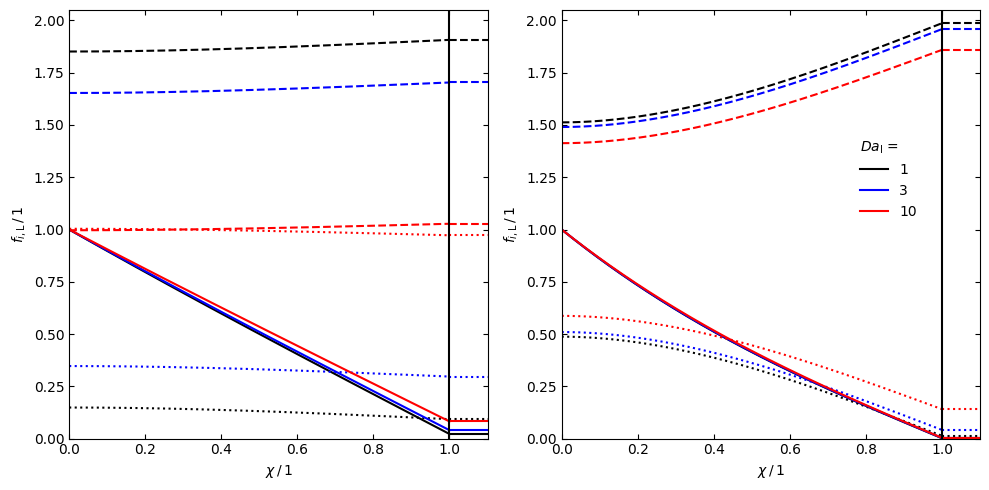

In [28]:
colors_Da = ['black','blue','red']

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
for Lösung, Da, color in zip(Lösungen_Ha_1,Da_I_vec,colors_Da):
    ax[0].plot(Lösung.x, Lösung.y[0], label = str(Da), color = color)
    ax[0].hlines(y=Lösung.y[0][-1], xmin=1, xmax=1.1, colors = color)
    ax[0].plot(Lösung.x, Lösung.y[1], color = color, linestyle = '--')
    ax[0].hlines(y=Lösung.y[1][-1], xmin=1, xmax=1.1, colors = color, linestyle = '--')
    ax[0].plot(Lösung.x, Lösung.y[2], color = color, linestyle = ':')
    ax[0].hlines(y=Lösung.y[2][-1], xmin=1, xmax=1.1, colors = color, linestyle = ':')

for Lösung, Da, color in zip(Lösungen_Ha_2,Da_I_vec,colors_Da):
    ax[1].plot(Lösung.x, Lösung.y[0], label = str(Da), color = color)
    ax[1].hlines(y=Lösung.y[0][-1], xmin=1, xmax=1.1, colors = color)
    ax[1].plot(Lösung.x, Lösung.y[1], color = color, linestyle = '--')
    ax[1].hlines(y=Lösung.y[1][-1], xmin=1, xmax=1.1, colors = color, linestyle = '--')
    ax[1].plot(Lösung.x, Lösung.y[2], color = color, linestyle = ':')
    ax[1].hlines(y=Lösung.y[2][-1], xmin=1, xmax=1.1, colors = color, linestyle = ':')

ax[0].vlines(x=1, ymin=0, ymax=3, colors='black')
ax[0].set_xlim(0,1.1)
ax[0].set_ylim(0,2.05)
ax[0].tick_params(axis="y",direction="in", right = True)
ax[0].tick_params(axis="x",direction="in", top = True)
ax[0].set_ylabel(r'$f_{i,\mathrm{L}}\,/\,1$')
ax[0].set_xlabel(r'$\chi \,/\,1$')

ax[1].vlines(x=1, ymin=0, ymax=3, colors='black')
ax[1].set_ylabel(r'$f_{i,\mathrm{L}}\,/\,1$')
ax[1].set_xlabel(r'$\chi \,/\,1$')
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(0,2.05)
ax[1].tick_params(axis="y",direction="in", right = True)
ax[1].tick_params(axis="x",direction="in", top = True)
ax[1].legend(title = '$Da_\mathrm{I}$ =',frameon = False, alignment = 'left',ncol=1,loc=(0.7,0.5))
plt.tight_layout()
plt.show()

Weiter werden der Nutzungsgrad des Flüssigkeitsfilms $\eta_\mathrm{L,Film}$, der Nutzungsgrad der Kernströmung $\eta_\mathrm{L,b}$, der Nutzungsgradverlust $\Delta\eta_\mathrm{L}$ und der Verstärkungsfaktor $E$ ausgewertet.

In [29]:
Res_Ha_1 = [] # leere Liste zum Speichern der Ergebnisse für verschiedene Ha = 0,3
Res_Ha_2 = [] # leere Liste zum Speichern der Ergebnisse für verschiedene Ha = 1
Res_Ha_3 = [] # leere Liste zum Speichern der Ergebnisse für verschiedene Ha = 10

# Berechnung für Ha = 0,3
for Lösung, Da in zip(Lösungen_Ha_1, Da_I_vec):
    Ha     = Ha_vec[0]
    Da_I   = Da
    Res    = np.empty(4) # Array der Größe 4 zum Speichern von E, eta_L_Film, Delta_eta_L, eta_L_b
    Res[0] = cal_E(Lösung.y[3,0], Lösung.y[0,0], Lösung.y[0,-1])
    Res[1] = cal_eta_L_Film(Lösung.y[3,-1], Lösung.y[3,0])
    Res[2] = cal_Delta_eta_L(Hi, Ha, Da_I, Lösung.y[0,-1], Lösung.y[3,0])
    Res[3] = cal_eta_L_b(Res[1], Res[2])
    Res_Ha_1.append(Res)

Res_Ha_1 = np.array((Res_Ha_1))



# Berechnung für Ha = 1
for Lösung, Da in zip(Lösungen_Ha_2, Da_I_vec):
    Ha     = Ha_vec[1]
    Da_I   = Da
    Res    = np.empty(4) # Array der Größe 4 zum Speichern von E, eta_L_Film, Delta_eta_L, eta_L_b
    Res[0] = cal_E(Lösung.y[3,0], Lösung.y[0,0], Lösung.y[0,-1])
    Res[1] = cal_eta_L_Film(Lösung.y[3,-1], Lösung.y[3,0])
    Res[2] = cal_Delta_eta_L(Hi, Ha, Da_I, Lösung.y[0,-1], Lösung.y[3,0])
    Res[3] = cal_eta_L_b(Res[1], Res[2])
    Res_Ha_2.append(Res)

Res_Ha_2 = np.array((Res_Ha_2))

# Berechnung für Ha = 10
for Lösung, Da in zip(Lösungen_Ha_3, Da_I_vec):
    Ha     = Ha_vec[2]
    Da_I   = Da
    Res    = np.empty(4) # Array der Größe 4 zum Speichern von E, eta_L_Film, Delta_eta_L, eta_L_b
    Res[0] = cal_E(Lösung.y[3,0], Lösung.y[0,0], Lösung.y[0,-1])
    Res[1] = cal_eta_L_Film(Lösung.y[3,-1], Lösung.y[3,0])
    Res[2] = cal_Delta_eta_L(Hi, Ha, Da_I, Lösung.y[0,-1], Lösung.y[3,0])
    Res[3] = cal_eta_L_b(Res[1], Res[2])
    Res_Ha_3.append(Res)

Res_Ha_3 = np.array((Res_Ha_3))

comb_Res        = np.hstack((Res_Ha_1.T, Res_Ha_2.T ,Res_Ha_3.T)) # Kombinierter Vektor der Ergebnisse
comb_Res[[2,3]] = comb_Res[[3,2]]                                 # Tauschen der letzten mit der vorletzten Reihe

Die Ausgabe der Ergebnisse erfolgt tabellarisch.

In [30]:
# Ausgabe der Ergebnisse als Tabelle

names_y  = np.array((['Ha / 1'], ['Da_I / 1'], ['E / 1'], ['eta_L_Film / 1'], ['eta_L_b / 1'], ['Delta_eta_L / 1']))
Ha_table = np.array((0.3, 0.3, 0.3, 1, 1, 1, 10, 10, 10))  
Da_table = np.array((1, 3, 10, 1, 3, 10, 1, 3, 10))

# Array für Tabelle
table = np.hstack((names_y,np.vstack((Ha_table, Da_table, np.round(comb_Res,2)))))

print(tabulate(table))

---------------  ----  ----  -----  ----  ----  -----  -----  -----  -----
Ha / 1           0.3   0.3    0.3   1     1      1     10     10     10
Da_I / 1         1     3     10     1     3     10      1      3     10
E / 1            1.06  1.05   1.03  1.48  1.47   1.45   2.97   2.97   2.96
eta_L_Film / 1   0.08  0.08   0.05  0.48  0.48   0.46   1      1      1
eta_L_b / 1      0.73  0.8    0.87  0.41  0.46   0.51   0      0      0
Delta_eta_L / 1  0.19  0.12   0.08  0.1   0.06   0.03   0      0      0
---------------  ----  ----  -----  ----  ----  -----  -----  -----  -----


Erwartungsgemäß ist kein Unterschied in den ersten zwei Nachkommastellen beim Vergleich der Ergebnisse beider Ansätze festzustellen. Der Ansatz über die Biot-Zahl scheint deshalb ein guter alternativer und allgemeinerer Lösungsweg zu sein.